In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch specific
import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import wandb

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [2]:
# Importerer spaleron og micro svarte hull data

module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
import trainers
import nnmodels

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

Running on the GPU


In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
print(bhArray.shape)
print(sphArray.shape)

(15000, 50, 50, 3)
(15000, 50, 50, 3)


In [5]:
# Vi slår sammen dataene for å ha et samlet datasett som kjører gjennom modellen
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
# 75% av datasettet havner i trainData, 25% havner i testData, 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [9]:
# gjør det om til en tensor fra numpy array. Vi gjør dette for at at dataene skal være lagret på GPU en istedet for en liste som er lagret på CPUen 
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [10]:
# to tensor datasett 
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [11]:
from torchvision import models
from torchsummary import summary

model = nnmodels.ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                 [-1, 1000]       2,305,000
           Dropout-5                 [-1, 1000]               0
            Linear-6                    [-1, 2]           2,002
Total params: 2,464,442
Trainable params: 2,464,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.69
Params size (MB): 9.40
Estimated Total Size (MB): 10.12
----------------------------------------------------------------


In [12]:
config = {
    'model': 'cnn',
    'loss': 'cross',
    'epoch': 100,
    'batch_size': 50,
    'gamma': 0.99,
    'learning_rate': 0.01,
    'optimizer': 'adam',
    'dropout': 0
}

run = wandb.init(project="Run", config=config, name=config['model'] + "_" + config['loss'] + "_" + config['optimizer']+ "_" + str(config['gamma']))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 591291 (g13hvl2023). Use `wandb login --relogin` to force relogin


In [13]:
model, y_pred, y_true = trainers.run(train, test, config)

[Text(0, 0.5, 'Microscopic black holes'), Text(0, 1.5, 'Sphaleron')]

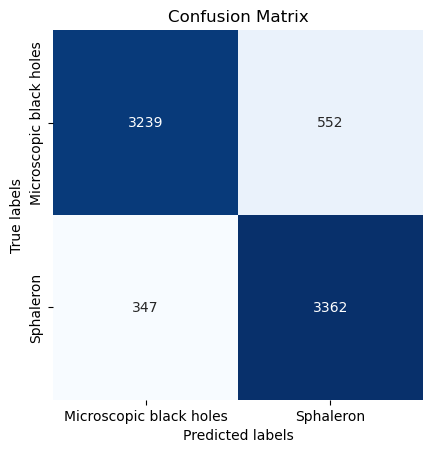

In [14]:
matrix_confusion = confusion_matrix([x.data.cpu().numpy() for x in y_true], [x.data.cpu().numpy() for x in y_pred], labels=[0,1])
ax= plt.subplot()
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Microscopic black holes', 'Sphaleron'])
ax.yaxis.set_ticklabels(['Microscopic black holes', 'Sphaleron'])

In [15]:
y_pred_numpy = [x.data.cpu().numpy() for x in y_pred]
y_true_numpy = [x.data.cpu().numpy() for x in y_true]
sum([x == y for (x, y) in zip(y_pred_numpy, y_true_numpy) if y == 0.0])/len([x for x in y_true_numpy if x == 0.0])

0.8543919810076497

In [16]:
#Eksempel på hva model gir som output mot labels
testLoader = DataLoader(test, shuffle=True, batch_size=config['batch_size'])
a = next(iter(testLoader))  
output = model(a[0].permute(0,3,1,2).to(device))

for i in range(10):
    print("output: ", output[i].data.cpu().numpy(),"labels: ", a[1][i].data.cpu().numpy())


output:  [-0.06868958  0.11502254] labels:  0.0
output:  [ 3.7233253 -3.5981925] labels:  0.0
output:  [-1.270407   1.2917678] labels:  1.0
output:  [-1.9554362  1.8569319] labels:  1.0
output:  [ 1.4029185 -1.3260047] labels:  0.0
output:  [-0.3903972  0.430045 ] labels:  0.0
output:  [ 0.25747895 -0.204368  ] labels:  0.0
output:  [-1.5124418  1.5287731] labels:  1.0
output:  [ 4.204409  -4.0692787] labels:  0.0
output:  [-1.5088854  1.524002 ] labels:  0.0


In [17]:
#Eksempel på hva model gir som output mot labels
testLoader = DataLoader(test, shuffle=True, batch_size=config['batch_size'])
a = next(iter(testLoader))
output = model(a[0].permute(0,3,1,2).to(device))

list = torch.max(output.to(device), 1)[1] #Snakket om 16.03.2023, gir pred output

for i in range(10):
    print("output: ", list[i].data.cpu().numpy(),"labels: ", a[1][i].data.cpu().numpy())




output:  0 labels:  0.0
output:  0 labels:  0.0
output:  0 labels:  0.0
output:  0 labels:  0.0
output:  1 labels:  1.0
output:  1 labels:  1.0
output:  0 labels:  0.0
output:  0 labels:  0.0
output:  1 labels:  1.0
output:  0 labels:  0.0
